In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
%matplotlib inline

In [2]:
def cam_calib(images):
    
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in images: 
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6),flags= cv2.CALIB_CB_FAST_CHECK)


        if ret == True:

            objpoints.append(objp)

            imgpoints.append(corners)

            # Displaying the corners
            corner_img = cv2.drawChessboardCorners(img, (9,6), corners,ret)

    #Distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    

    return ret, mtx, dist, rvecs, tvecs

In [3]:
def abs_xsobel_thresh(img, orient='x', Thresh_min=20, Thresh_max=60):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    xsobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    
    xsobel_abs = np.absolute(xsobel)
   
    
    scaled_xsobel = np.uint8(255*xsobel_abs/np.max(xsobel_abs))
    
    
    sxbinary = np.zeros_like(scaled_xsobel)
    sxbinary[(scaled_xsobel>=Thresh_min) & (scaled_xsobel<=Thresh_max)] = 1
    
    return sxbinary

def abs_ysobel_thresh(img, orient='y', Thresh_min=20, Thresh_max=100):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    ysobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
   
    ysobel_abs = np.absolute(ysobel)
    
    
    scaled_ysobel = np.uint8(255*ysobel_abs/np.max(ysobel_abs))
    
    sybinary = np.zeros_like(scaled_ysobel)
    sybinary[(scaled_ysobel>=Thresh_min) & (scaled_ysobel<=Thresh_max)] = 1
    
    return sybinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(20, 100)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output


def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    xsobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    ysobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_xsobel = np.absolute(xsobel)
    abs_ysobel = np.absolute(ysobel)
    
    direction = np.arctan2(abs_ysobel,abs_xsobel)
    
    binary = np.zeros_like(direction)
    binary[(direction>=thresh[0]) & (direction<=thresh[1])] = 1
    
    return binary


def s_threshold(img, sobel_kernel=17, thresh=(170, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

     # Threshold color channel
    s_thresh_min = thresh[0]
    s_thresh_max = thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    return s_binary

def l_threshold(img, sobel_kernel=17, thresh=(170, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

     # Threshold color channel
    l_thresh_min = thresh[0]
    l_thresh_max = thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    return l_binary

def h_threshold(img, sobel_kernel=17, thresh=(170, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

     # Threshold color channel
    h_thresh_min = thresh[0]
    h_thresh_max = thresh[1]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    
    return h_binary

def y_threshold(img, sobel_kernel=17, thresh=(215, 255)):

    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y_channel = yuv[:,:,0]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

     # Threshold color channel
    y_thresh_min = thresh[0]
    y_thresh_max = thresh[1]
    y_binary = np.zeros_like(y_channel)
    y_binary[(y_channel >= y_thresh_min) & (y_channel <= y_thresh_max)] = 1
    
    return y_binary

def mask_image(image):

    ysize = image.shape[0]
    xsize = image.shape[1]
    region_select = np.copy(image)


    left_bottom = [0, 539]
    right_bottom = [900, 300]
    apex = [400, 0]


    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    region_select[region_thresholds] = [255, 0, 0]
    
    return region_select

def warp_image(img):
    img_size = (img.shape[1],img.shape[0])

    src = np.float32(
    [[(img_size[0] / 2) - 57, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 20), img_size[1]],
    [(img_size[0] * 5 / 6)+10, img_size[1]],
    [(img_size[0] / 2 + 57), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0]/4), 0],
    [(img_size[0]/4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    FinalImage = cv2.warpPerspective(img,M,img_size)
    
    return FinalImage

def unwarp_image(img):
    img_size = (img.shape[1],img.shape[0])

    src = np.float32(
    [[(img_size[0] / 2) - 57, img_size[1] / 2 + 100],
    [((img_size[0] / 6) + 20), img_size[1]],
    [(img_size[0] * 5 / 6)+10, img_size[1]],
    [(img_size[0] / 2 + 57), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] /4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(dst,src)
    FinalImage = cv2.warpPerspective(img,M,img_size)
    
    return FinalImage

def find_lane_pixels(warped_image):
    
    histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
    
    out_img = np.dstack((warped_image, warped_image, warped_image))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 3
    
    margin = 50

    minpix = 4

    window_height = np.int(warped_image.shape[0]//nwindows)
    
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy<=win_y_high) & (nonzeroy>=win_y_low) & (nonzerox<=win_xleft_high) & (nonzerox>=win_xleft_low)).nonzero()[0]
        good_right_inds = ((nonzeroy<=win_y_high) & (nonzeroy>=win_y_low) & (nonzerox<=win_xright_high) & (nonzerox>=win_xright_low)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(left_lane_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(right_lane_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
       
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
 
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(image):

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)

    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    
    return left_fit,right_fit,ploty


def detect_lane(warped_image):
    
    margin = 450

    left_fit, right_fit, ploty = fit_polynomial(warped_image)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:

        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)

    out_img = np.dstack((warped_image, warped_image, warped_image))*255
    window_img = np.zeros_like(out_img)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-10, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+10, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))


    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

def car_position(image):
    
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    left_fit,right_fit,ploty = fit_polynomial(image)
    camera_position = image.shape[0]/2
    lane_center = (right_fit[1] + left_fit[1])//2
    center_offset_pixels = abs(camera_position - lane_center)
    
    return (lane_center*xm_per_pix)
    
    
    
def measure_curvature_pixels(image):
    
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    left_fit, right_fit, ploty = fit_polynomial(image)
    
    y_eval = np.max(ploty)*ym_per_pix
    
    left_fit_cr = left_fit * xm_per_pix
    right_fit_cr = right_fit * xm_per_pix
    
    left_curverad = ((1+((2*left_fit[0]*y_eval)+ left_fit[1])**2)**(3/2))/(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+((2*right_fit[0]*y_eval)+ right_fit[1])**2)**(3/2))/(2*right_fit[0])  ## Implement the calculation of the right line here
    
    return int(left_curverad), int(right_curverad)



In [4]:
def rad_of_curvature(image):
    
    test_image = image

    grad_x = abs_xsobel_thresh(test_image, orient='x', Thresh_min=30, Thresh_max=150)
    
    mag_binary = mag_thresh(test_image, sobel_kernel=9, mag_thresh=(100, 105))
    
    s_binary = s_threshold(test_image, sobel_kernel=17, thresh=(150,255))
    
    l_binary = l_threshold(test_image, sobel_kernel=17, thresh=(150,255))
    
    y_binary = y_threshold(test_image, sobel_kernel=17, thresh=(150,255))

    combined = np.zeros_like(mag_binary)
    combined[((grad_x == 1) | (s_binary == 1) & (l_binary == 1) & (y_binary == 1))] = 1

    warped = warp_image(combined)
    
    Radius = measure_curvature_pixels(warped)
    
    return Radius

def car_distance(image):
    
    test_image = image

    grad_x = abs_xsobel_thresh(test_image, orient='x', Thresh_min=30, Thresh_max=150)
    
    mag_binary = mag_thresh(test_image, sobel_kernel=9, mag_thresh=(100, 105))
    
    s_binary = s_threshold(test_image, sobel_kernel=17, thresh=(170,255))
    
    l_binary = l_threshold(test_image, sobel_kernel=17, thresh=(170,255))
    
    y_binary = y_threshold(test_image, sobel_kernel=17, thresh=(170,255))

    combined = np.zeros_like(mag_binary)
    combined[((grad_x == 1) | (s_binary == 1) & (l_binary == 1) & (y_binary == 1))] = 1
    
    distance = car_position(combined)
    return distance

def Pipeline(original_image):
    
    test_image = original_image

    grad_x = abs_xsobel_thresh(test_image, orient='x', Thresh_min=30, Thresh_max=150)
    grad_y = abs_ysobel_thresh(test_image, orient='y', Thresh_min=20, Thresh_max=100)
    mag_binary = mag_thresh(test_image, sobel_kernel=9, mag_thresh=(100, 105))
    dir_binary = dir_threshold(test_image, sobel_kernel=15, thresh=(0.1, 1.0))
    s_binary = s_threshold(test_image, sobel_kernel=17, thresh=(100,255))
    l_binary = l_threshold(test_image, sobel_kernel=17, thresh=(80,255))
    h_binary = h_threshold(test_image, sobel_kernel=17, thresh=(150,255))
    y_binary = y_threshold(test_image, sobel_kernel=17, thresh=(20,255))
    color_binary = np.dstack(( np.zeros_like(grad_x), grad_x, s_binary)) * 255

    combined = np.zeros_like(mag_binary)
    combined[((grad_x == 1) | (y_binary == 1) & (s_binary == 1) & (l_binary == 1))] = 1

    warped = warp_image(combined)

    Window_Image = detect_lane(warped)

    Unwarped_Image = unwarp_image(Window_Image)
    
    Final_Image = cv2.addWeighted(test_image, 1, Unwarped_Image, 0.3, 0)
    
    Radius = rad_of_curvature(Final_Image)
    
    Car_Position = car_distance(Final_Image)

    cv2.putText(Final_Image,"Radius of Curvature is " + str(Radius)+ "m", (100,100), 2, 1, (255,255,0),2)

    cv2.putText(Final_Image,"Distance from center is {:2f}".format(Car_Position)+ "m", (100,150), 2, 1, (255,255,0),2)

    return Final_Image

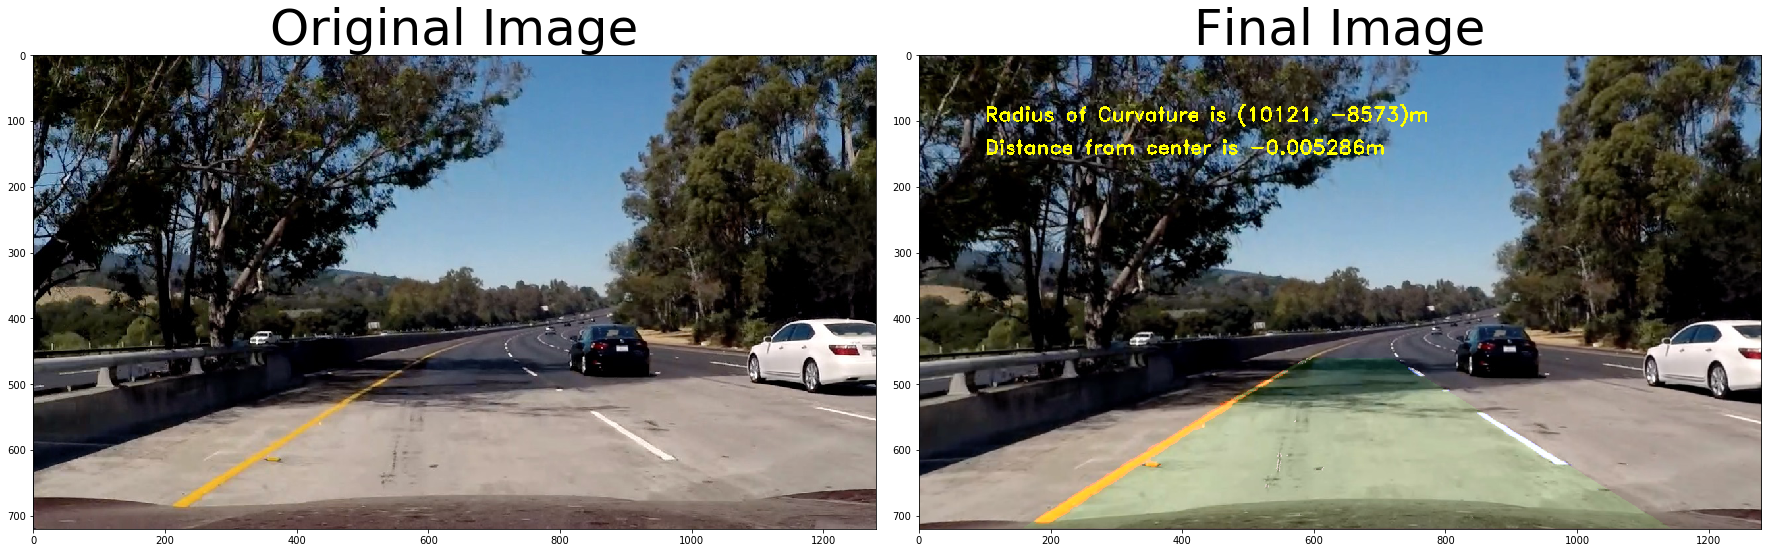

In [5]:
cam_images = glob.glob('camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = cam_calib(cam_images)

original_image = plt.imread('test_images/test5.jpg')

undistorted = cv2.undistort(original_image, mtx, dist, None, mtx)

final_image = Pipeline(undistorted)




f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(final_image)
ax2.set_title('Final Image', fontsize=50)
ax1.imshow(original_image)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 49min 21s


In [7]:
<video width="960" height="540" controls>
<source src="{0}">
</video>""".format(project_video_output))

SyntaxError: invalid syntax (<ipython-input-7-60830ec738b2>, line 1)